<a href="https://colab.research.google.com/github/weso500/IOT-Anomaly-Detection/blob/main/Single_Image_VAE_Working_Large_Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Obtained intially from https://keras.io/examples/generative/vae/ and https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/generative/ipynb/vae.ipynb

In [1]:
pip install --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 23.6 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.4.1 which is incompatible.


In [2]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras
from keras import ops
from keras import layers

In [3]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

Use this notebook as example for obtaining images: https://colab.research.google.com/drive/1EOFDisibXb9a4A3lZ_2z4Jbhlnx0OVy6 The below takes care of obtaining images

In [4]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(256, 256, 3))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 262144)         │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 16)             │      4,194,320 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 2)              │             34 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 2)              │             34 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling (Sampling)       │ (None, 2)              │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,213,780 (16.07 MB)

 Trainable params: 4,213,780 (16.07 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(64 * 64 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((64, 64, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 262144)              │         786,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 256, 256, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 256, 256, 3)         │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 842,691 (3.21 MB)

 Trainable params: 842,691 (3.21 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    def call(self, inputs):  # Add the call method
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        return reconstructed

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = ops.mean(
                ops.sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2),
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [7]:
!unzip /content/Compiled_Data.zip

Streaming output truncated to the last 5000 lines.
  inflating: Compiled_Data/Normal/Spectrograms_Normal_A+_IGBT-I/342Normal.png  
  inflating: Compiled_Data/Normal/Spectrograms_Normal_A+_IGBT-I/326Normal.png  
  inflating: Compiled_Data/Normal/Spectrograms_Normal_MOD-V/194Normal.png  
  inflating: Compiled_Data/Normal/Spectrograms_Normal_A+_IGBT-I/348Normal.png  
  inflating: Compiled_Data/Normal/Spectrograms_Normal_MOD-V/187Normal.png  
  inflating: Compiled_Data/Normal/Spectrograms_Normal_A+_IGBT-I/324Normal.png  
  inflating: Compiled_Data/Normal/Spectrograms_Normal_MOD-V/198Normal.png  
  inflating: Compiled_Data/Normal/Spectrograms_Normal_A+_IGBT-I/325Normal.png  
  inflating: Compiled_Data/Normal/Spectrograms_Normal_MOD-V/193Normal.png  
  inflating: Compiled_Data/Normal/Spectrograms_Normal_MOD-V/186Normal.png  
  inflating: Compiled_Data/Normal/Spectrograms_Normal_MOD-V/202Normal.png  
  inflating: Compiled_Data/Normal/Spectrograms_Normal_A+_IGBT-I/320Normal.png  
  inflating: 

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  '/content/Compiled_Data/Normal/Spectrograms_Normal_A+IGBT-I',
  image_size=(256, 256),
  batch_size=32,
  label_mode=None)

normalization_layer = layers.Rescaling(scale= 1./255)

normalized_ds = train_ds.map(lambda x: normalization_layer(x))

Found 690 files.


In [15]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  '/content/Compiled_Data/Anomaly/Spectrograms_Anomaly_A+IGBT-I',
  image_size=(256, 256),
  batch_size=32,
  label_mode=None)

normalization_layer = layers.Rescaling(scale= 1./255)

normalized_test_ds = test_ds.map(lambda x: normalization_layer(x))

Found 182 files.


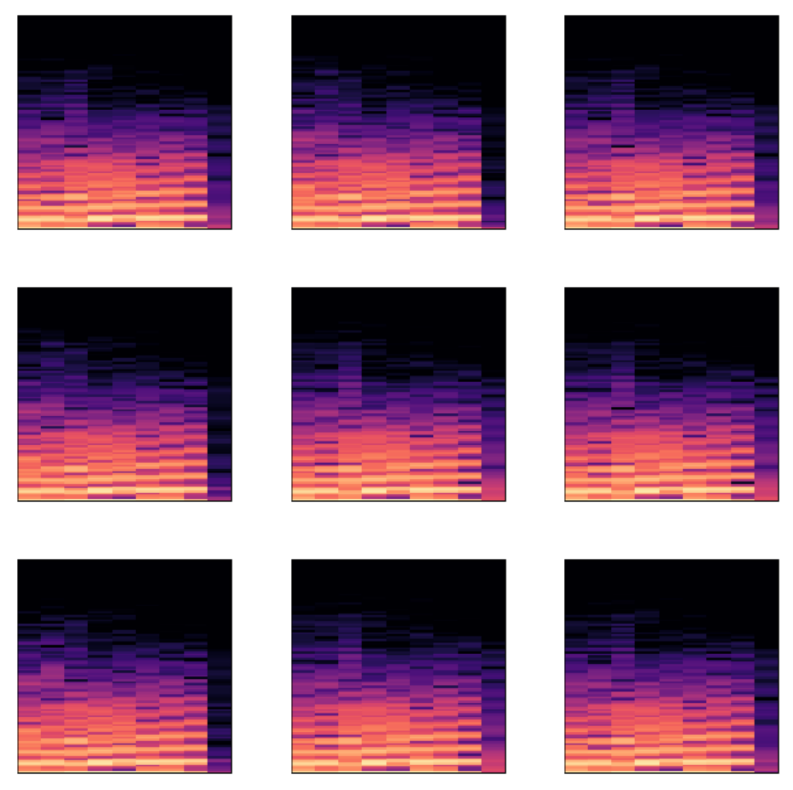

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

In [12]:
#(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
#mnist_digits = np.concatenate([x_train, x_test], axis=0)
#mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(normalized_ds, epochs=60, batch_size=10)

Epoch 1/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 37s 697ms/step - kl_loss: 537.4751 - loss: 41886.1406 - reconstruction_loss: 41348.6680
Epoch 2/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - kl_loss: 248.9836 - loss: 29050.4160 - reconstruction_loss: 28801.4316
Epoch 3/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - kl_loss: 97.3235 - loss: 27493.4609 - reconstruction_loss: 27396.1367
Epoch 4/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - kl_loss: 77.8561 - loss: 25747.9297 - reconstruction_loss: 25670.0723
Epoch 5/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - kl_loss: 74.5928 - loss: 23797.5801 - reconstruction_loss: 23722.9883
Epoch 6/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - kl_loss: 96.1791 - loss: 22102.3652 - reconstruction_loss: 22006.1855
Epoch 7/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - kl_loss: 111.4517 - loss: 21188.3711 - reconstruction_loss: 21076.9199
Epoch 8/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - kl_loss: 84.6800 - loss: 20905.0605 - reconstruction_loss: 20820.3789
Epoch 9/60


In [13]:
pip install sewar

  Preparing metadata (setup.py) ... done
  Created wheel for sewar: filename=sewar-0.4.6-py3-none-any.whl size=11419 sha256=7e17bdf24b7440a90dfe7a1b14ff2c119c50b1891c1a5e8b2e3612b41786ad02
  Stored in directory: /root/.cache/pip/wheels/3f/af/02/9c6556ba287b62a945d737def09b8b8c35c9e1d82b9dfae84c
Successfully built sewar


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━

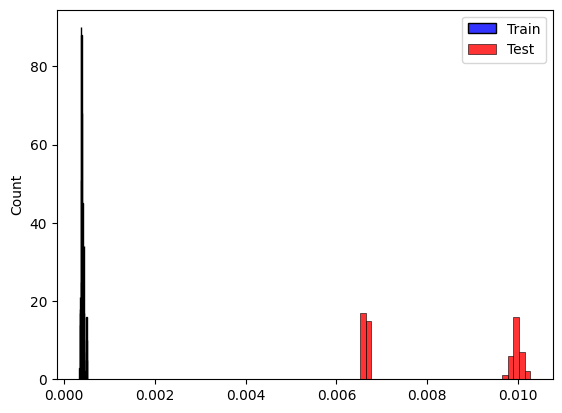

In [17]:
from sewar.full_ref import mse, rmse, psnr, uqi, ssim, ergas, scc, rase, sam, msssim, vifp
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

mse_values_train = [] # Create an empty list to store mse values
mse_values_test = []

for elem in normalized_ds.take(20):
  for i in range(len(elem)):
    elem_np = elem.numpy()
    exp = vae.predict(elem)
    exp_np = tf.get_static_value(exp)
    x = mse(elem_np, exp_np)
    mse_values_train.append(x) # Append each mse value to the list

for elem in normalized_test_ds.take(2):
  for i in range(len(elem)):
    elem_np = elem.numpy()
    exp = vae.predict(elem)
    exp_np = tf.get_static_value(exp)
    x = mse(elem_np, exp_np)
    mse_values_test.append(x) # Append each mse value to the list

#loss_threshold = np.percentile(mse_values, 95) # Calculate the threshold on the list of mse values
#print(f'The prediction loss threshold for 2% of outliers is {loss_threshold:.2f}')

# Visualize the threshold using the list of mse values
sns.histplot(mse_values_train, bins=30, alpha=0.8, color='blue', label='Train')
sns.histplot(mse_values_test, bins=30, alpha=0.8, color='red', label='Test')
#plt.axvline(x=loss_threshold, color='orange')
plt.legend()
plt.show()